<a href="https://colab.research.google.com/github/Youssefelsayed148/Bert-fake-new-classifier/blob/main/Bert_Fake_News.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install numpy==1.26.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 42.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


# Importing Libraries and data

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("saurabhshahane/fake-news-classification")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fake-news-classification


In [ ]:
import numpy as np
print(np.__version__)

1.26.4


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
import torch
from datasets import load_dataset,DatasetDict,Dataset
from transformers import  AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding, EarlyStoppingCallback
import json
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 500)

In [ ]:
csv_path = os.path.join(path, "WELFake_Dataset.csv")

df = pd.read_csv(csv_path)
print(df.head())


   Unnamed: 0  \
0           0   
1           1   
2           2   
3           3   
4           4   

                                                                                                                                       title  \
0         LAW ENFORCEMENT ON HIGH ALERT Following Threats Against Cops And Whites On 9-11By #BlackLivesMatter And #FYF911 Terrorists [VIDEO]   
1                                                                                                                                        NaN   
2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MOST CHARLOTTE RIOTERS WERE “PEACEFUL” PROTESTERS…In Her Home State Of North Carolina [VIDEO]   
3                                  Bobby Jindal, raised Hindu, uses story of Christian conversion to woo evangelicals for potential 2016 bid   
4                                            SATAN 2: Russia unvelis an image of its terrifying new ‘SUPERNUKE’ – Western world takes notice   

                                

# Exploratory Data Analysis (EDA)

label
1    37106
0    35028
Name: count, dtype: int64


<Axes: title={'center': 'Class Distribution'}, xlabel='label'>

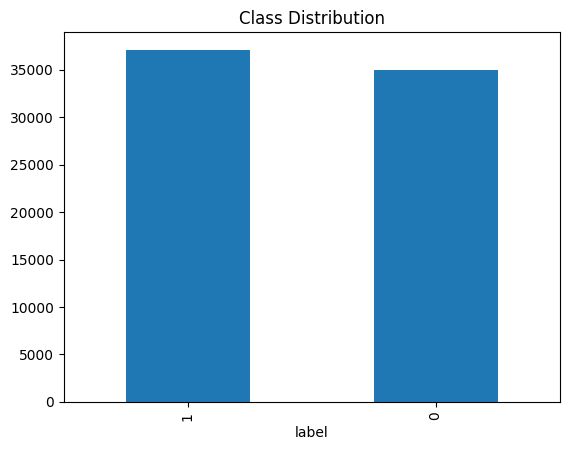

In [ ]:
# Class distribution
print(df['label'].value_counts())
df['label'].value_counts().plot(kind='bar', title='Class Distribution')


In [ ]:
df.isna().sum()

,0
Unnamed: 0,0
title,558
text,39
label,0


In [ ]:
print("Real News Example:")
print(df[df["label"] == 0]["text"].iloc[0][:500])

print("Fake News Example:")
print(df[df["label"] == 1]["text"].iloc[0][:500])


Real News Example:
A dozen politically active pastors came here for a private dinner Friday night to hear a conversion story unique in the context of presidential politics: how Louisiana Gov. Bobby Jindal traveled from Hinduism to Protestant Christianity and, ultimately, became what he calls an “evangelical Catholic.”

Over two hours, Jindal, 42, recalled talking with a girl in high school who wanted to “save my soul,” reading the Bible in a closet so his parents would not see him and feeling a stir while watching
Fake News Example:
No comment is expected from Barack Obama Members of the #FYF911 or #FukYoFlag and #BlackLivesMatter movements called for the lynching and hanging of white people and cops. They encouraged others on a radio show Tuesday night to  turn the tide  and kill white people and cops to send a message about the killing of black people in America.One of the F***YoFlag organizers is called  Sunshine.  She has a radio blog show hosted from Texas called,  Sunshine s F***

# Preprocessing data

In [ ]:
df.columns

Index(['Unnamed: 0', 'title', 'text', 'label'], dtype='object')

In [ ]:
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threats Against Cops And Whites On 9-11By #BlackLivesMatter And #FYF911 Terrorists [VIDEO],"No comment is expected from Barack Obama Members of the #FYF911 or #FukYoFlag and #BlackLivesMatter movements called for the lynching and hanging of white people and cops. They encouraged others on a radio show Tuesday night to turn the tide and kill white people and cops to send a message about the killing of black people in America.One of the F***YoFlag organizers is called Sunshine. She has a radio blog show hosted from Texas called, Sunshine s F***ing Opinion Radio Show. A snapshot ...",1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MOST CHARLOTTE RIOTERS WERE “PEACEFUL” PROTESTERS…In Her Home State Of North Carolina [VIDEO],"Now, most of the demonstrators gathered last night were exercising their constitutional and protected right to peaceful protest in order to raise issues and create change. Loretta Lynch aka Eric Holder in a skirt",1
3,3,"Bobby Jindal, raised Hindu, uses story of Christian conversion to woo evangelicals for potential 2016 bid","A dozen politically active pastors came here for a private dinner Friday night to hear a conversion story unique in the context of presidential politics: how Louisiana Gov. Bobby Jindal traveled from Hinduism to Protestant Christianity and, ultimately, became what he calls an “evangelical Catholic.”\n\nOver two hours, Jindal, 42, recalled talking with a girl in high school who wanted to “save my soul,” reading the Bible in a closet so his parents would not see him and feeling a stir while wa...",0
4,4,SATAN 2: Russia unvelis an image of its terrifying new ‘SUPERNUKE’ – Western world takes notice,"The RS-28 Sarmat missile, dubbed Satan 2, will replace the SS-18 Flies at 4.3 miles (7km) per sec and with a range of 6,213 miles (10,000km) The weapons are perceived as part of an increasingly aggressive Russia It could deliver a warhead of 40 megatons – 2,000 times as powerful as the atom bombs dropped on Hiroshima and Nagasaki in 1945 By LIBBY PLUMMER and GARETH DAVIE S Russia has unveiled chilling pictures of its largest ever nuclear missile, capable of destroying an area the size of Fra...",1


In [ ]:
df= df.drop(['Unnamed: 0','title'],axis=1)

In [ ]:
df.head()

,text,label
0,"No comment is expected from Barack Obama Members of the #FYF911 or #FukYoFlag and #BlackLivesMatter movements called for the lynching and hanging of white people and cops. They encouraged others on a radio show Tuesday night to turn the tide and kill white people and cops to send a message about the killing of black people in America.One of the F***YoFlag organizers is called Sunshine. She has a radio blog show hosted from Texas called, Sunshine s F***ing Opinion Radio Show. A snapshot ...",1
1,Did they post their votes for Hillary already?,1
2,"Now, most of the demonstrators gathered last night were exercising their constitutional and protected right to peaceful protest in order to raise issues and create change. Loretta Lynch aka Eric Holder in a skirt",1
3,"A dozen politically active pastors came here for a private dinner Friday night to hear a conversion story unique in the context of presidential politics: how Louisiana Gov. Bobby Jindal traveled from Hinduism to Protestant Christianity and, ultimately, became what he calls an “evangelical Catholic.”\n\nOver two hours, Jindal, 42, recalled talking with a girl in high school who wanted to “save my soul,” reading the Bible in a closet so his parents would not see him and feeling a stir while wa...",0
4,"The RS-28 Sarmat missile, dubbed Satan 2, will replace the SS-18 Flies at 4.3 miles (7km) per sec and with a range of 6,213 miles (10,000km) The weapons are perceived as part of an increasingly aggressive Russia It could deliver a warhead of 40 megatons – 2,000 times as powerful as the atom bombs dropped on Hiroshima and Nagasaki in 1945 By LIBBY PLUMMER and GARETH DAVIE S Russia has unveiled chilling pictures of its largest ever nuclear missile, capable of destroying an area the size of Fra...",1


In [ ]:
df.dropna(inplace=True)

In [ ]:
df.isna().sum()

,0
text,0
label,0


In [ ]:
train_df, temp_df= train_test_split(df,test_size=0.3,random_state=42,stratify=df['label'])
val_df, test_df= train_test_split(temp_df,test_size=0.5,random_state=42,stratify=temp_df['label'])

In [ ]:
dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
    "validation": Dataset.from_pandas(val_df.reset_index(drop=True)),
    "test": Dataset.from_pandas(test_df.reset_index(drop=True)),
})


In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 50466
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 10814
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 10815
    })
})

# Tokenizing and Modelling

In [ ]:
model_checkpoint= 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model= AutoModelForSequenceClassification.from_pretrained(model_checkpoint,num_labels=2)

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [ ]:
tokenized_dataset=dataset= dataset.map(preprocess_function,batched=True)

In [ ]:
# Rename label
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

# Remove unused columns and set format
for split in tokenized_dataset:
    tokenized_dataset[split] = tokenized_dataset[split].remove_columns(["text"])
    tokenized_dataset[split].set_format("torch")


In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 50466
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10814
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10815
    })
})

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="binary")
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}


# Training

In [ ]:
model.config.id2label = {0: "REAL", 1: "FAKE"}
model.config.label2id = {"REAL": 0, "FAKE": 1}

In [ ]:
training_args = TrainingArguments(
    output_dir="fake_news_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    fp16=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
trainer.train()

/tmp/ipython-input-25-3469616163.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: youssefelsayed1480 (youssefelsayed1480-freelance) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

# Evaluation

In [ ]:
metrics = trainer.evaluate(tokenized_dataset["test"])
print(metrics)

In [ ]:
metrics_df= pd.DataFrame([metrics])
metrics_df

# Saving

In [ ]:
project_dir= "Bert-Fake-News-Model"
os.makedirs(project_dir,exist_ok=True)

In [ ]:
with open(f"{project_dir}/final_metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

In [ ]:
metrics_df.to_csv(f"{project_dir}/metrics.csv",index=False)

In [ ]:
trainer.save_model(project_dir)
tokenizer.save_pretrained(project_dir)

In [ ]:
from huggingface_hub import notebook_login,create_repo,HfApi

notebook_login()

In [ ]:
api = HfApi()

# Create the repository if it doesn't exist
repo_name = "Bert-fake-news-detector"
repo_id = f"Youssef-El-SaYed/{repo_name}" # Replace Youssef-El-SaYed with your Hugging Face username
create_repo(repo_id, repo_type="model", exist_ok=True)

api.upload_folder(
    folder_path="Bert-Fake-News-Model",
    repo_id=repo_id,
    repo_type="model"
)


In [ ]:
trainer.push_to_hub("Bert-Fake-News-Model")
tokenizer.push_to_hub("Bert-Fake-News-Model")
